In [12]:
import base64
from functools import wraps
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
from torch import distributions, nn
import torch.nn.functional as F
import time
import tqdm

%matplotlib inline
jtplot.style()

device = torch.device('cuda')

## Pytorch layer and model definitions

In [13]:
class FullyConnectedGNNLayer(nn.Module):
    def __init__(self, n_nodes, in_features, out_features, activation_func=nn.ReLU(), squeeze_out=False):
        super().__init__()
        self.n_nodes = n_nodes
        self.activation_func = activation_func
        self.transform_features = nn.Linear(in_features, out_features)
        self.message_passing_mat = nn.Parameter(
            (torch.ones((n_nodes, n_nodes)) - torch.eye(n_nodes)) / (n_nodes - 1),
            requires_grad=False
        )
        self.recombine_features = nn.Linear(out_features*2, out_features)
        self.squeeze_out = squeeze_out
    
    def forward(self, features):
        features_transformed = self.activation_func(
            self.transform_features(features)
        )
        messages = torch.matmul(self.message_passing_mat, features_transformed)
        features_messages_combined = self.activation_func(
            self.recombine_features(torch.cat([features_transformed, messages], dim=-1))
        )
        if self.squeeze_out:
            return features_messages_combined.squeeze(dim=-1)
        else:
            return features_messages_combined
        

class GraphNN_A3C(nn.Module):
    def __init__(self, in_features, n_nodes):
        super().__init__()
        # Define network
        activation_func = nn.ReLU()
        layer_size = 16
        layers = (
            [FullyConnectedGNNLayer(n_nodes, in_features, layer_size, activation_func=activation_func)] +
            [FullyConnectedGNNLayer(n_nodes, layer_size, layer_size, activation_func=activation_func)] * 1
        )
        self.base = nn.Sequential(*layers)
        self.actor = FullyConnectedGNNLayer(n_nodes, layer_size, 1, activation_func=activation_func, squeeze_out=True)
        self.critic = FullyConnectedGNNLayer(n_nodes, layer_size, 1, activation_func=nn.Identity(), squeeze_out=True)
        
        self.train()
    
    def forward(self, states):
        base_out = self.base(states)
        return self.actor(base_out), self.critic(base_out).mean(dim=-1)
    
    def sample_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            probs = F.softmax(logits, dim=-1)
            batch_size, n_envs, n_players, n_bandits = probs.shape
            m = torch.distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
            return m.sample().view(batch_size, n_envs, n_players)
    
    def choose_best_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            return logits.argmax(dim=-1)
    
    def loss_func(self, states, actions, v_t):
        #print(f'states.shape: {states.shape}, actions.shape: {actions.shape}, v_t.shape: {v_t.shape}')
        logits, values = self.forward(states)
        
        #print(f'logits.shape: {logits.shape}, values.shape: {values.shape}')
        td = v_t - values
        critic_loss = td.pow(2).view(-1)
        
        probs = F.softmax(logits, dim=-1)
        batch_size, n_envs, n_players, n_bandits = probs.shape
        m = torch.distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
        #print(f'm.log_prob(actions.view(batch_size * n_envs * n_players)).shape: {m.log_prob(actions.view(batch_size * n_envs * n_players)).shape}, td.shape: {td.shape}')
        actor_loss = -(m.log_prob(actions.view(-1)) * td.detach().view(-1))
        total_loss = (critic_loss + actor_loss).mean()
        return total_loss

## Vectorized recreation of environment

In [14]:
END_OF_GAME = 0
EVERY_STEP = 1
class Kaggle_MAB_Env_Torch_Vectorized():
    def __init__(self,
                 # Kaggle MAB env params
                 n_bandits=100, n_steps=1999, decay_rate=0.97, sample_resolution=100,
                 # Custom params
                 n_envs=1, n_players=2, reward_type=EVERY_STEP, normalize_reward=True, remove_extra_dims=False, env_device=torch.device('cuda'), out_device=torch.device('cuda')):
        # Assert parameter conditions
        assert 0 <= decay_rate <= 1.
        assert reward_type in (END_OF_GAME, EVERY_STEP)
        if reward_type == END_OF_GAME:
            assert n_players >= 2
        else:
            assert n_players >= 1
        self.n_bandits = n_bandits
        self.n_steps = n_steps
        self.decay_rate = decay_rate
        self.sample_resolution = sample_resolution
        
        self.n_envs = n_envs
        self.n_players = n_players
        self.reward_type = reward_type
        if not normalize_reward or self.reward_type == END_OF_GAME:
            self.r_norm = 1.
        else:
            #self.r_norm = 1 / self.n_steps
            self.r_norm = 1 / (np.sum(self.decay_rate ** np.arange(self.n_steps)) * np.arange(self.n_bandits).sum() / (self.n_bandits * self.n_players))
        self.remove_extra_dims = remove_extra_dims
        self.env_device = env_device
        self.out_device = out_device
        
        self.timestep = None
        self.orig_thresholds = None
        self.player_n_pulls = None
        self.player_rewards_sums = None
        self.reset()
        
    def _out_device_decorator(f):
        @wraps(f)
        def wrapped(self, *args, **kwargs):
            return [out.to(self.out_device) if torch.is_tensor(out) else out for out in f(self, *args, **kwargs)]
        return wrapped
    
    @_out_device_decorator
    def reset(self):
        self.timestep = 0
        self.orig_thresholds = torch.randint(self.sample_resolution + 1, size=(self.n_envs, self.n_bandits), dtype=torch.float32, device=self.env_device)
        self.player_n_pulls = torch.zeros((self.n_envs, self.n_players, self.n_bandits), device=self.env_device)
        self.player_rewards_sums = torch.zeros_like(self.player_n_pulls)
        
        rewards = torch.zeros((self.n_envs, self.n_players), device=self.env_device) * self.r_norm
        if self.remove_extra_dims:
            rewards = rewards.squeeze()
        return self.obs, rewards, self.done, self.info_dict
    
    @_out_device_decorator
    def step(self, actions):
        if self.remove_extra_dims:
            if type(actions) == int:
                actions = torch.tensor([[actions]], device=self.env_device)
            else:
                actions = actions.view((self.n_envs, self.n_players))
        assert actions.shape == (self.n_envs, self.n_players), f'actions.shape was: {actions.shape}'
        assert not self.done
        self.timestep += 1
        actions = actions.to(self.env_device)
        
        # Compute agent rewards
        selected_thresholds = self.thresholds.gather(-1, actions)
        pull_rewards = torch.randint(self.sample_resolution, size=selected_thresholds.shape, dtype=torch.float32, device=self.env_device) < selected_thresholds
        #pull_rewards = selected_thresholds / self.sample_resolution
        
        # Update player_n_pulls and player_rewards_sums
        #for env_idx, env_actions in enumerate(actions):
        #    for player_idx, pull_idx in enumerate(env_actions):
        #        self.player_n_pulls[env_idx, :, pull_idx] += 1
        #        self.player_rewards_sums[env_idx, player_idx, pull_idx] += pull_rewards[env_idx, player_idx]
        """
        actions_expanded = actions.unsqueeze(1).expand(-1, self.n_players, -1)
        self.player_n_pulls.scatter_(
            -1,
            actions_expanded,
            self.player_n_pulls.gather(-1, actions_expanded) + 1
        )
        """
        envs_idxs = torch.arange(self.n_envs).repeat_interleave(self.n_players)
        players_idxs = torch.arange(self.n_players).repeat(self.n_envs)
        self.player_n_pulls[
            envs_idxs,
            players_idxs,
            actions.view(-1)
        ] += 1.
        self.player_rewards_sums[
            envs_idxs,
            players_idxs,
            actions.view(-1)
        ] += pull_rewards.view(-1)
        
        # Return (obs, reward, done) tuple
        if self.reward_type == END_OF_GAME:
            rewards = torch.zeros_like(actions).float()
            if self.timestep == self.n_steps:
                rewards_sums = self.player_rewards_sums.sum(dim=2)
                winners = rewards_sums.argmax(dim=1)
                rewards[winners] = 1.
        elif self.reward_type == EVERY_STEP:
            rewards = pull_rewards
        
        rewards = rewards * self.r_norm
        # State, reward, done, info_dict
        if self.remove_extra_dims:
            rewards = rewards.squeeze()
        return self.obs, rewards, self.done, self.info_dict
    
    @property
    def obs(self):
        # Duplicate and reshape player_n_pulls such that each player receives a tensor of shape (1,1,n_bandits,n_players)
        # The final axis contains the player's num_pulls first and other player actions listed afterwards
        # This is currently not implemented for more than 2 players
        if self.n_players == 1:
            obs = torch.stack([
                self.player_n_pulls,
                self.player_rewards_sums
            ], dim=-1)
        elif self.n_players == 2:
            player_n_pulls_player_relative = torch.stack([
                self.player_n_pulls,
                self.player_n_pulls[:,[1,0],:]
            ], dim=-1)
            obs = torch.cat([
                player_n_pulls_player_relative,
                self.player_rewards_sums.unsqueeze(-1)
            ], dim=-1)
        else:
            raise RuntimeError('n_players > 2 is not currently supported by obs() due to relative player pulls info')
        if self.remove_extra_dims:
            obs = obs.squeeze()
        return obs * self.n_bandits / self.n_steps
    
    @property
    def thresholds(self):
        return self.orig_thresholds * (self.decay_rate ** self.player_n_pulls.sum(dim=1))
    
    @property
    def done(self):
        return self.timestep >= self.n_steps
    
    @property
    def info_dict(self):
        if self.remove_extra_dims:
            info_dict = {
                'thresholds': self.thresholds.squeeze(),
                'true_player_rewards_sums': self.player_rewards_sums.squeeze(),
            }
        else:
            info_dict = {
                'thresholds': self.thresholds,
                'true_player_rewards_sums': self.player_rewards_sums,
            }
        return info_dict

## A3C RL algorithm

In [15]:
def a3c_vectorized_env(env, model, optimizer, n_episodes, batch_size,
                       gamma=0.9):
    model.to(device=device)
    model.train()
    episode_reward_sums = []
    
    for episode in tqdm.trange(n_episodes):
        buffer_s, buffer_a, buffer_r = [], [], []
        s, r, _, _ = env.reset()
        episode_reward_sums.append(r)
        step_count = 1
        while not env.done:
            # Batch size of 1 for inference
            a = model.sample_action(s.to(device=device).unsqueeze(0)).squeeze(0)
            next_s, r, done, _ = env.step(a)
            
            #print(s.shape, a.shape, r.shape)
            buffer_s.append(s)
            buffer_a.append(a)
            buffer_r.append(r)
            
            if step_count % batch_size == 0 or done:
                if done:
                    v_next_s = torch.zeros_like(buffer_r[-1])
                else:
                    _, v_next_s = model(next_s.to(device=device).unsqueeze(0))
                    v_next_s = v_next_s.detach().squeeze(0)
                v_next_s.to(device=device)
                
                buffer_v_target = []
                for r in buffer_r[::-1]:
                    v_next_s = r + gamma * v_next_s
                    buffer_v_target.append(v_next_s)
                buffer_v_target.reverse()
                
                loss = model.loss_func(
                    torch.stack(buffer_s).to(device=device),
                    torch.stack(buffer_a).to(device=device),
                    torch.stack(buffer_v_target).to(device=device)
                )
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                buffer_s, buffer_a, buffer_r = [], [], []
            s = next_s
            episode_reward_sums[-1] += r
            step_count += 1
    return [rs.mean() for rs in episode_reward_sums]

## RL training
#### TODO:
Use a better parameter initialization - load the previous model and study the parameter distribution to learn from it relative to a fresh model?

Adjust size of GNN - add more layers?

Tune gamma and/or batch_size

Eventually, experiment with reward_type = END_OF_GAME

In [16]:
env = Kaggle_MAB_Env_Torch_Vectorized(n_envs=512, n_players=2, decay_rate=0.97, out_device=device)
model = GraphNN_A3C(3, env.n_bandits)
model.to(device=device)
optimizer = torch.optim.Adam(model.parameters())

rl_alg_kwargs = dict(
    batch_size=60,
    gamma=0.99
)
episode_reward_sums = a3c_vectorized_env(env, model, optimizer, n_episodes=25, **rl_alg_kwargs)

100%|██████████| 25/25 [04:00<00:00,  9.62s/it]


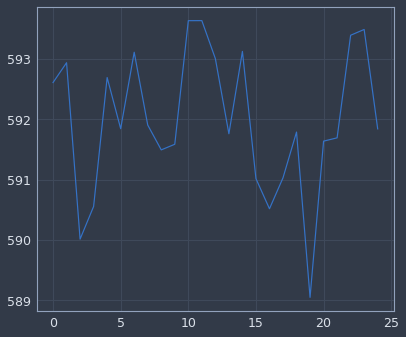

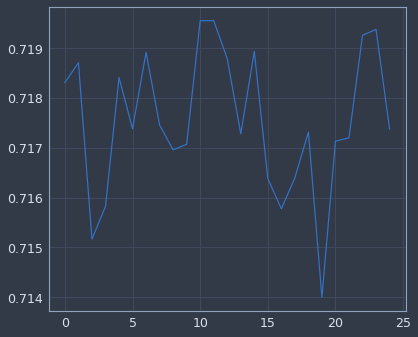

In [17]:
plt.plot([rs / env.r_norm for rs in episode_reward_sums])
plt.show()
plt.plot(episode_reward_sums);

In [21]:
episode_reward_sums = a3c_vectorized_env(env, model, optimizer, n_episodes=25, **rl_alg_kwargs)

100%|██████████| 25/25 [03:46<00:00,  9.07s/it]


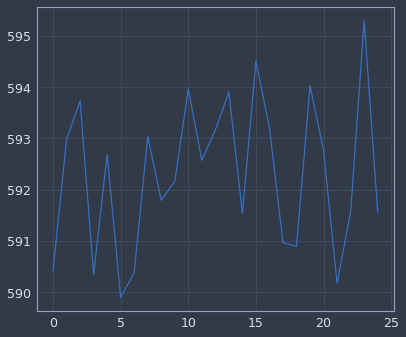

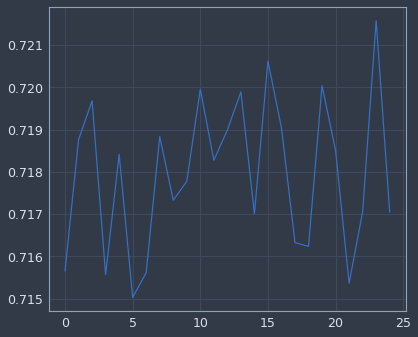

In [23]:
#rewards = reinforce(env, policy_est, batch_size=2, num_episodes=100)
plt.plot([rs / env.r_norm for rs in episode_reward_sums])
plt.show()
plt.plot(episode_reward_sums);

## Save the model state_dict as a serialized string

In [116]:
model.to('cpu')
state_dict_bytes = pickle.dumps({
    'model_state_dict': model.state_dict(),
    #'optimizer_state_dict': optimizer.state_dict()
})
serialized_string = base64.b64encode(state_dict_bytes)
with open('rl_agents/s_s.txt', 'w') as f:
    f.write(repr(serialized_string))

## Testing and debugging

In [77]:
test_env = Kaggle_MAB_Env_Torch_Vectorized(n_envs=3, n_players=2, decay_rate=0.97, env_device=torch.device('cpu'), out_device=device)
test_env.reset()
actions = torch.arange(6).view(3,2)
test_env.step(actions)
test_env.step(actions)
actions = torch.arange(1,7).view(3,2)
test_env.step(actions)
test_env.step(actions)
test_env.step(actions)

test = test_env.player_n_pulls.unsqueeze(3).expand(-1,-1,-1,2).transpose(1,3)
test = torch.cat([
    test[:,0,:,:].unsqueeze(1),
    test[:,0,:,[1,0]].unsqueeze(1)
], dim=1)
test[0,0]
test_env.player_rewards_sums

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [10]:
from scipy.stats import spearmanr, pearsonr

test_env = Kaggle_MAB_Env_Torch_Vectorized(n_players=2, decay_rate=0.97)
with torch.no_grad():
    test_env.reset()
    # Take 50 good actions
    for i in range(50):
        actions = test_env.thresholds.argmax(axis=-1)[:, None]
        s, _, _, _ = test_env.step(actions.repeat(1, test_env.n_players))
    logits, values = model(s[0,0].to(device=device)[None, None, :])
    logits = logits.cpu().numpy().squeeze()
    values = values.cpu().numpy().squeeze()
print()
print(logits)
print(values)
print(s[:,0].squeeze().t())
print(spearmanr(logits, test_env.thresholds.squeeze().cpu().numpy())[0],
      pearsonr(logits, test_env.thresholds.squeeze().cpu().numpy())[0])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.0015577442
tensor([[0.1501, 0.0000, 0.0500, 0.0000, 0.0000, 0.0000, 0.0000, 0.2001, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0500, 0.0500, 0.0000, 0.1001, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.1001, 0.1501, 0.0000, 0.0000, 0.0000,
         0.1501, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1501, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.2001, 0.0000, 0.0000, 0.0000, 0.0500, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1501, 0.0000, 0.2001, 0.0000, 0.0500, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0500, 0.0000,

In [11]:
child_layer_idx = -1
child_layer = list(model.children())[child_layer_idx]
print(child_layer.transform_features.weight.data, child_layer.transform_features.bias.data)
print(child_layer.recombine_features.weight.data, child_layer.recombine_features.bias.data)
print(model)
print(child_layer)

tensor([[ 0.0262,  0.1752, -0.0545,  0.1121, -0.1307, -0.2462,  0.0642,  0.1453,
          0.1664, -0.2003, -0.1945,  0.1583,  0.0691, -0.0952, -0.0247, -0.0223]],
       device='cuda:0') tensor([0.0936], device='cuda:0')
tensor([[-0.1309,  0.2959]], device='cuda:0') tensor([-0.0018], device='cuda:0')
GraphNN_A3C(
  (base): Sequential(
    (0): FullyConnectedGNNLayer(
      (activation_func): ReLU()
      (transform_features): Linear(in_features=3, out_features=16, bias=True)
      (recombine_features): Linear(in_features=32, out_features=16, bias=True)
    )
    (1): FullyConnectedGNNLayer(
      (activation_func): ReLU()
      (transform_features): Linear(in_features=16, out_features=16, bias=True)
      (recombine_features): Linear(in_features=32, out_features=16, bias=True)
    )
    (2): FullyConnectedGNNLayer(
      (activation_func): ReLU()
      (transform_features): Linear(in_features=16, out_features=16, bias=True)
      (recombine_features): Linear(in_features=32, out_featur

In [10]:
test_env = Kaggle_MAB_Env_Torch_Vectorized(n_envs=1000, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=torch.device('cuda'))

for i in tqdm.trange(test_env.n_steps):
    actions = torch.randint(test_env.n_bandits, size=(test_env.n_envs, test_env.n_players))
    test_env.step(actions)
test_env.player_rewards_sums.sum(axis=-1).mean(), test_env.player_rewards_sums.sum(axis=-1).std()

100%|██████████| 1999/1999 [00:01<00:00, 1586.75it/s]


(tensor(591.1075, device='cuda:0'), tensor(38.6730, device='cuda:0'))

In [11]:
test_env = Kaggle_MAB_Env_Torch_Vectorized(n_envs=1000, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=torch.device('cpu'))

for i in tqdm.trange(test_env.n_steps):
    actions = test_env.thresholds.argmax(axis=-1)[:, None]
    test_env.step(actions.repeat(1, test_env.n_players))
test_env.player_rewards_sums.sum(axis=-1).mean(), test_env.player_rewards_sums.sum(axis=-1).std()

100%|██████████| 1999/1999 [00:01<00:00, 1052.65it/s]


(tensor(661.2520, device='cuda:0'), tensor(37.1968, device='cuda:0'))

In [152]:
n_nodes = 10
activation_func = nn.ReLU()
layer_size = 64
layers = (
    [FullyConnectedGNNLayer(n_nodes, 1, layer_size, activation_func=activation_func)] +
    [FullyConnectedGNNLayer(n_nodes, layer_size, layer_size, activation_func=activation_func)] * 0 +
    [FullyConnectedGNNLayer(n_nodes, layer_size, 1, activation_func=activation_func)]
)
model = nn.Sequential(
    *layers
)
#model = FullyConnectedGNNLayer(n_nodes, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for i in tqdm.trange(10):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

test_batch_in = torch.rand((1, n_nodes, 1), dtype=torch.float).to('cuda')
print(test_batch_in)
print(F.softmax(model(test_batch_in), dim=1))
print(torch.topk(test_batch_in, k=k, dim=1).indices[:,k-1])
print(F.softmax(model(test_batch_in), dim=1).argmax(dim=1))

100%|██████████| 10/10 [00:00<00:00, 479.15it/s]

Loss: 2.30, Accuracy: 0.000
tensor([[[0.8214],
         [0.5663],
         [0.7303],
         [0.6139],
         [0.0942],
         [0.2026],
         [0.8251],
         [0.3299],
         [0.0296],
         [0.5319]]], device='cuda:0')
tensor([[[0.1007],
         [0.1003],
         [0.1006],
         [0.1004],
         [0.0990],
         [0.0994],
         [0.1007],
         [0.0997],
         [0.0988],
         [0.1003]]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[0]], device='cuda:0')
tensor([[6]], device='cuda:0')


In [153]:
for i in tqdm.trange(1000):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

100%|██████████| 1000/1000 [00:01<00:00, 549.97it/s]

Loss: 2.29, Accuracy: 0.000


In [250]:
model = FullyConnectedGNNLayer(5, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.)

for i in tqdm.trange(10000):
    train_batch_in = torch.rand((1024, 5, 1), dtype=torch.float).to('cuda')
    train_batch_out = train_batch_in + train_batch_in.sum(dim=1, keepdims=True)
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, train_batch_out)
    loss.backward()
    optimizer.step()
loss

100%|██████████| 10000/10000 [00:08<00:00, 1172.83it/s]


tensor(2.2476e-11, device='cuda:0', grad_fn=<MseLossBackward>)

In [251]:
train_batch_in = torch.rand((2, 5, 1), dtype=torch.float).to('cuda')
print(train_batch_in)
print(train_batch_in + train_batch_in.sum(dim=1, keepdims=True))
print(model(train_batch_in))

tensor([[[0.8142],
         [0.2351],
         [0.0057],
         [0.8548],
         [0.5895]],

        [[0.9160],
         [0.7284],
         [0.4671],
         [0.4535],
         [0.1266]]], device='cuda:0')
tensor([[[3.3136],
         [2.7345],
         [2.5050],
         [3.3541],
         [3.0888]],

        [[3.6076],
         [3.4200],
         [3.1586],
         [3.1450],
         [2.8181]]], device='cuda:0')
tensor([[[3.3136],
         [2.7345],
         [2.5051],
         [3.3541],
         [3.0888]],

        [[3.6076],
         [3.4200],
         [3.1586],
         [3.1450],
         [2.8181]]], device='cuda:0', grad_fn=<AddBackward0>)


## Deprecated

In [ ]:
class Kaggle_MAB_Env_Numpy_Vectorized():
    def __init__(self,
                 # Kaggle MAB env params
                 n_bandits=100, n_steps=1999, decay_rate=0.97, sample_resolution=100,
                 # Custom params
                 n_envs=1, n_players=2, reward_type=EVERY_STEP, remove_extra_dims=False):
        # Assert parameter conditions
        assert 0 <= decay_rate <= 1.
        assert reward_type in (END_OF_GAME, EVERY_STEP)
        if reward_type == END_OF_GAME:
            assert n_players >= 2
        else:
            assert n_players >= 1
        self.n_bandits = n_bandits
        self.n_steps = n_steps
        self.decay_rate = decay_rate
        self.sample_resolution = sample_resolution
        
        self.n_envs = n_envs
        self.n_players = n_players
        self.reward_type = reward_type
        self.remove_extra_dims = remove_extra_dims
        
        self.timestep = None
        self.orig_thresholds = None
        self.player_n_pulls = None
        self.player_rewards_sums = None
        self.reset()
    
    @property
    def thresholds(self):
        return self.orig_thresholds * (self.decay_rate ** self.player_n_pulls[:,0,:])
    
    def reset(self):
        self.timestep = 0
        self.orig_thresholds = np.random.randint(self.sample_resolution + 1, size=(self.n_envs, self.n_bandits)).astype(np.float32)
        self.player_n_pulls = np.zeros((self.n_envs, self.n_players, self.n_bandits))
        self.player_rewards_sums = np.zeros_like(self.player_n_pulls)
        
        rewards = np.zeros((self.n_envs, self.n_players))
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
        
    def step(self, actions):
        if self.remove_extra_dims:
            if type(actions) == int:
                actions = np.array([[actions]])
            else:
                actions = actions.reshape((self.n_envs, self.n_players))
        assert actions.shape == (self.n_envs, self.n_players), f'actions.shape was: {actions.shape}'
        assert not self.done
        self.timestep += 1
        
        # Compute agent rewards
        selected_thresholds = np.take_along_axis(self.thresholds, actions, axis=1)
        pull_rewards = np.random.randint(self.sample_resolution, size=selected_thresholds.shape) < selected_thresholds
        #pull_rewards = selected_thresholds / float(self.sample_resolution)
        
        # Update player_n_pulls and player_rewards_sums
        for env_idx, env_actions in enumerate(actions):
            for player_idx, pull_idx in enumerate(env_actions):
                self.player_n_pulls[env_idx, :, pull_idx] += 1
                self.player_rewards_sums[env_idx, player_idx, pull_idx] += pull_rewards[env_idx, player_idx]
        
        # Return (obs, reward, done) tuple
        if self.reward_type == END_OF_GAME:
            rewards = np.zeros_like(actions)
            if self.timestep == self.n_steps:
                rewards_sums = self.player_rewards_sums.sum(axis=2)
                winners = rewards_sums.argmax(axis=1)
                rewards[winners] = 1
        elif self.reward_type == EVERY_STEP:
            rewards = pull_rewards
        
        # State, reward, done, info_dict
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
    
    def get_obs(self):
        # TODO: Clearly do not return thresholds or orig_thresholds
        return np.stack([
            #np.broadcast_to(self.orig_thresholds[:, None, :] / self.sample_resolution, self.player_n_pulls.shape),
            self.player_n_pulls,
            self.player_rewards_sums
        ], axis=-1).astype(np.float32)
    
    @property
    def done(self):
        return self.timestep >= self.n_steps